# Training-aware quantization of Wav2Vec2 on GPU


Before we start, let's install both `datasets`,  `transformers` and `librosa`.

In [1]:
# %%capture
# !pip install datasets==1.18.3
# !pip install transformers==4.17.0
# !pip install jiwer
# !pip install librosa

In [2]:
device = 'cuda'

In [3]:
# ! git clone https://github.com/NVIDIA/TensorRT.git

In [4]:
# ! cd TensorRT/tools/pytorch-quantization && pip install .

## Prepare Data, Tokenizer, Feature Extractor

ASR models transcribe speech to text, which means that we both need a feature extractor that processes the speech signal to the model's input format, *e.g.* a feature vector, and a tokenizer that processes the model's output format to text.

In Transformers, the Wav2Vec2 model is thus accompanied by both a tokenizer, called [Wav2Vec2CTCTokenizer](https://huggingface.co/transformers/master/model_doc/wav2vec2.html#wav2vec2ctctokenizer), and a feature extractor, called [Wav2Vec2FeatureExtractor](https://huggingface.co/transformers/master/model_doc/wav2vec2.html#wav2vec2featureextractor).

Let's start by creating the tokenizer responsible for decoding the model's predictions.

### Create Wav2Vec2CTCTokenizer

Let's start by loading the dataset and taking a look at its structure.

In [5]:
from datasets import load_dataset, load_metric

timit = load_dataset("timit_asr")

Reusing dataset timit_asr (/home/kmb85/.cache/huggingface/datasets/timit_asr/clean/2.0.1/b11b576ddcccbcefa7c9f0c4e6c2a43756f3033adffe0fb686aa61043d0450ad)


  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
timit

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'text', 'phonetic_detail', 'word_detail', 'dialect_region', 'sentence_type', 'speaker_id', 'id'],
        num_rows: 4620
    })
    test: Dataset({
        features: ['file', 'audio', 'text', 'phonetic_detail', 'word_detail', 'dialect_region', 'sentence_type', 'speaker_id', 'id'],
        num_rows: 1680
    })
})

In [7]:
timit = timit.remove_columns(["phonetic_detail", "word_detail", "dialect_region", "id", "sentence_type", "speaker_id"])

We normalize the text to only have lower case letters and append a word separator token at the end.

In [8]:
import re
chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"]'

def remove_special_characters(batch):
    batch["text"] = re.sub(chars_to_ignore_regex, '', batch["text"]).lower() + " "
    return batch

In [9]:
timit = timit.map(remove_special_characters)

Parameter 'function'=<function remove_special_characters at 0x7f35fa131ab0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

We write a mapping function that concatenates all transcriptions into one long transcription and then transforms the string into a set of chars.
It is important to pass the argument `batched=True` to the `map(...)` function so that the mapping function has access to all transcriptions at once.

In [10]:
def extract_all_chars(batch):
  all_text = " ".join(batch["text"])
  vocab = list(set(all_text))
  return {"vocab": [vocab], "all_text": [all_text]}

In [11]:
vocabs = timit.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=timit.column_names["train"])

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Now, we create the union of all distinct letters in the training dataset and test dataset and convert the resulting list into an enumerated dictionary.

In [12]:
vocab_list = list(set(vocabs["train"]["vocab"][0]) | set(vocabs["test"]["vocab"][0]))

In [13]:
vocab_dict = {v: k for k, v in enumerate(vocab_list)}
vocab_dict

{'v': 0,
 'l': 1,
 'z': 2,
 'f': 3,
 'o': 4,
 'u': 5,
 'e': 6,
 'i': 7,
 'b': 8,
 'w': 9,
 'x': 10,
 'k': 11,
 'y': 12,
 's': 13,
 'n': 14,
 'g': 15,
 'c': 16,
 ' ': 17,
 'p': 18,
 'a': 19,
 'j': 20,
 'q': 21,
 'r': 22,
 't': 23,
 'd': 24,
 "'": 25,
 'h': 26,
 'm': 27}

Finally, we also add a padding token that corresponds to CTC's "*blank token*". The "blank token" is a core component of the CTC algorithm. For more information, please take a look at the "Alignment" section [here](https://distill.pub/2017/ctc/).

In [14]:
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]

In [15]:
vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
len(vocab_dict)

30

Let's now save the vocabulary as a json file.

In [16]:
import json
with open('vocab.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

In a final step, we use the json file to instantiate an object of the `Wav2Vec2CTCTokenizer` class.

In [17]:
from transformers import Wav2Vec2CTCTokenizer

tokenizer = Wav2Vec2CTCTokenizer("./vocab.json", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")

### Create Wav2Vec2 Feature Extractor

In [18]:
from transformers import Wav2Vec2FeatureExtractor

feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=False)

In [19]:
from transformers import Wav2Vec2Processor

processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

Next, we can prepare the dataset.

Let's apply the data preparation function to all examples.

In [20]:
def prepare_dataset(batch):
    audio = batch["audio"]

    batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
    batch["input_length"] = len(batch["input_values"])

    with processor.as_target_processor():
        batch["labels"] = processor(batch["text"]).input_ids
    return batch

In [21]:
timit = timit.map(prepare_dataset, remove_columns=timit.column_names["train"], num_proc=4)

2023-12-09 22:21:30.758372: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-09 22:21:30.758373: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-09 22:21:30.758565: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-09 22:21:30.758566: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-09 22:21:30.758686: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register fa

In [22]:
max_input_length_in_sec = 4.0
timit["train"] = timit["train"].filter(lambda x: x < max_input_length_in_sec * processor.feature_extractor.sampling_rate, input_columns=["input_length"])

  0%|          | 0/5 [00:00<?, ?ba/s]

Now we are ready to start training!

### Set-up Trainer

Let's start by defining the data collator. The code for the data collator was copied from [this example](https://github.com/huggingface/transformers/blob/9a06b6b11bdfc42eea08fa91d0c737d1863c99e3/examples/research_projects/wav2vec2/run_asr.py#L81).

In [23]:
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

In [24]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

Next, the evaluation metric is defined. As mentioned earlier, the
predominant metric in ASR is the word error rate (WER), hence we will use it in this notebook as well.

In [25]:
wer_metric = load_metric("wer")

The model will return a sequence of logit vectors:
$\mathbf{y}_1, \ldots, \mathbf{y}_m$ with $\mathbf{y}_1 = f_{\theta}(x_1, \ldots, x_n)[0]$ and $n >> m$.

In [26]:
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

In [27]:
from transformers import Wav2Vec2ForCTC, Trainer

2023-12-09 22:24:02.077042: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-09 22:24:02.077283: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-09 22:24:02.077455: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-09 22:24:02.117385: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-09 22:24:06.758017: W tensorflow/compiler/

## Base Model Training

In [28]:
model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-base",
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
)
model = model.to(device)

/home/kmb85/.local/lib/python3.10/site-packages/transformers/configuration_utils.py:356: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
/home/kmb85/.local/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
Some weights of the model checkpoint at facebook/wav2vec2-base were not used when initializing Wav2Vec2ForCTC: ['project_hid.weight', 'quantizer.codevectors', 'project_q.bias', 'quantizer.weight_proj.weight', 'quantizer.weight_proj.bias', 'project_hid.bias', 'project_q.weight']
- This IS expected i

In [ ]:
model.eval()

In [29]:
model.freeze_feature_encoder()

In [30]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="wav2vec2-base-timit-demo-google-colab",
  group_by_length=True,
  per_device_train_batch_size=128,
  evaluation_strategy="steps",
  num_train_epochs=1,
  fp16=False,
  gradient_checkpointing=True,
  save_steps=500,
  eval_steps=500,
  logging_steps=500,
  learning_rate=1e-4,
  weight_decay=0.005,
  warmup_steps=1000,
  save_total_limit=2,
)

In [31]:
trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=timit["train"],
    eval_dataset=timit["test"],
    tokenizer=processor.feature_extractor,
)

In [32]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: input_length. If input_length are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
/home/kmb85/.local/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3978
  Num Epochs = 1
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 32
/home/kmb85/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The 

Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=32, training_loss=8.900426864624023, metrics={'train_runtime': 204.9497, 'train_samples_per_second': 19.41, 'train_steps_per_second': 0.156, 'total_flos': 1.0879110671022144e+17, 'train_loss': 8.900426864624023, 'epoch': 1.0})

## Quantization-Aware Training

In [34]:
import pytorch_quantization
from pytorch_quantization import nn as quant_nn
from pytorch_quantization import quant_modules
from pytorch_quantization.tensor_quant import QuantDescriptor
from pytorch_quantization import calib

In [35]:
print(pytorch_quantization.__version__)

2.1.3


In [36]:
quant_desc_input = QuantDescriptor(calib_method='max', num_bits=4, fake_quant=True)
quant_nn.QuantConv1d.set_default_quant_desc_input(quant_desc_input)
quant_nn.QuantLinear.set_default_quant_desc_input(quant_desc_input)

In [37]:
quant_modules.initialize()
model_quantized = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-base",
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
)

loading configuration file https://huggingface.co/facebook/wav2vec2-base/resolve/main/config.json from cache at /home/kmb85/.cache/huggingface/transformers/c7746642f045322fd01afa31271dd490e677ea11999e68660a92619ec7c892b4.ce1f96bfaf3d7475cb8187b9668c7f19437ade45fb9ceb78d2b06a2cec198015
/home/kmb85/.local/lib/python3.10/site-packages/transformers/configuration_utils.py:356: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Model config Wav2Vec2Config {
  "activation_dropout": 0.0,
  "adapter_kernel_size": 3,
  "adapter_stride": 2,
  "add_adapter": false,
  "apply_spec_augment": true,
  "architectures": [
    "Wav2Vec2ForPreTraining"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 1,
  "classifier_proj_size": 256,
  "codevector_dim": 256,

In [38]:
model_quantized = model_quantized.to(device)

In [39]:
model_quantized.freeze_feature_encoder()

First, calibrate the quantized model

In [40]:
for name, module in model_quantized.named_modules():
    if name.endswith('_quantizer'):
        module.enable_calib()
        module.disable_quant()

In [41]:
with torch.no_grad():
    for i in range(2000):
            _ = model_quantized(torch.tensor(timit["train"][i:i+1]["input_values"], device="cuda"))

In [42]:
# Finalize calibration
for name, module in model_quantized.named_modules():
    if name.endswith('_quantizer'):
        module.load_calib_amax()
        module.disable_calib()
        module.enable_quant()

# If running on GPU, it needs to call .cuda() again because new tensors will be created by calibration process
model_quantized.cuda()

W1209 22:33:31.147157 139871448428544 tensor_quantizer.py:238] Load calibrated amax, shape=torch.Size([]).
W1209 22:33:31.154291 139871448428544 tensor_quantizer.py:239] Call .cuda() if running on GPU after loading calibrated amax.
W1209 22:33:31.156030 139871448428544 tensor_quantizer.py:174] Disable MaxCalibrator
W1209 22:33:31.157454 139871448428544 tensor_quantizer.py:238] Load calibrated amax, shape=torch.Size([512, 1, 1]).
W1209 22:33:31.158857 139871448428544 tensor_quantizer.py:174] Disable MaxCalibrator
W1209 22:33:31.160705 139871448428544 tensor_quantizer.py:238] Load calibrated amax, shape=torch.Size([]).
W1209 22:33:31.162338 139871448428544 tensor_quantizer.py:174] Disable MaxCalibrator
W1209 22:33:31.163990 139871448428544 tensor_quantizer.py:238] Load calibrated amax, shape=torch.Size([512, 1, 1]).
W1209 22:33:31.165229 139871448428544 tensor_quantizer.py:174] Disable MaxCalibrator
W1209 22:33:31.166615 139871448428544 tensor_quantizer.py:238] Load calibrated amax, shap

Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): QuantConv1d(
            1, 512, kernel_size=(10,), stride=(5,), bias=False
            (_input_quantizer): TensorQuantizer(4bit fake per-tensor amax=22.2899 calibrator=MaxCalibrator scale=1.0 quant)
            (_weight_quantizer): TensorQuantizer(8bit fake axis=0 amax=[0.0119, 0.6792](512) calibrator=MaxCalibrator scale=1.0 quant)
          )
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1): Wav2Vec2NoLayerNormConvLayer(
          (conv): QuantConv1d(
            512, 512, kernel_size=(3,), stride=(2,), bias=False
            (_input_quantizer): TensorQuantizer(4bit fake per-tensor amax=131.2755 calibrator=MaxCalibrator scale=1.0 quant)
            (_weight_quantizer): TensorQuantizer(8bit fake axis=0 amax=[0.1276, 3.595

Once calibration is finished, we can perform Quantization Aware Training on GPU

In [43]:
trainer_quantized = Trainer(
    model=model_quantized,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=timit["train"],
    eval_dataset=timit["test"],
    tokenizer=processor.feature_extractor,
)

In [44]:
trainer_quantized.train()

The following columns in the training set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: input_length. If input_length are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
/home/kmb85/.local/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3978
  Num Epochs = 1
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=32, training_loss=8.680068016052246, metrics={'train_runtime': 209.4068, 'train_samples_per_second': 18.997, 'train_steps_per_second': 0.153, 'total_flos': 1.0879110671022144e+17, 'train_loss': 8.680068016052246, 'epoch': 1.0})

In [45]:
input_size = 100000
AUDIO_MAXLEN = input_size
dummy_input = torch.randn(1, input_size, requires_grad=True).cuda()

In [46]:
torch.onnx.export(model_quantized,
         dummy_input,
         "wav2vec2_qat.onnx",
         export_params=True,
         opset_version=10,
         do_constant_folding=True,
         input_names = ['modelInput'],
         output_names = ['modelOutput'],
         dynamic_axes={'modelInput' : {0 : 'batch_size'},
         'modelOutput' : {0 : 'batch_size'}}
) 

/home/kmb85/.local/lib/python3.10/site-packages/pytorch_quantization/tensor_quant.py:257: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if amax.numel() == 1:
/home/kmb85/.local/lib/python3.10/site-packages/pytorch_quantization/tensor_quant.py:260: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  axis = amax.shape.index(amax.numel())
/home/kmb85/.local/lib/python3.10/site-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:637: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow

### Base vs Quantized Model Inference Time

In [33]:
import time

input_size = 100000
AUDIO_MAXLEN = input_size
dummy_input = torch.randn(1, input_size, requires_grad=True).cuda()

starttime = time.time()
with torch.no_grad():
    model(dummy_input)

print(f'Base Model inference time {time.time() - starttime}')

Base Model inference time 0.0666208267211914


/home/kmb85/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


In [47]:
import onnxruntime as ort
ort.get_device()

'GPU'

In [48]:
import numpy as np
import tensorrt
ort_sess = ort.InferenceSession('wav2vec2_qat.onnx', providers=['TensorrtExecutionProvider'])

2023-12-09 22:39:06.228234515 [W:onnxruntime:Default, tensorrt_execution_provider.h:77 log] [2023-12-09 22:39:06 WARNING] onnx2trt_utils.cpp:374: Your ONNX model has been generated with INT64 weights, while TensorRT does not natively support INT64. Attempting to cast down to INT32.
2023-12-09 22:39:13.702230723 [W:onnxruntime:Default, tensorrt_execution_provider.h:77 log] [2023-12-09 22:39:13 WARNING] onnx2trt_utils.cpp:374: Your ONNX model has been generated with INT64 weights, while TensorRT does not natively support INT64. Attempting to cast down to INT32.


In [51]:
input_size = 100000
AUDIO_MAXLEN = input_size
dummy_input = torch.randn(1, input_size, requires_grad=True).detach().numpy() 
X_ortvalue = ort.OrtValue.ortvalue_from_numpy(dummy_input, 'cuda', 0)

In [52]:
import time

starttime = time.time()
with torch.no_grad():
    ort_sess.run(None, {"modelInput": X_ortvalue})
    
print(time.time() - starttime)

0.005755901336669922


Finally, we visualise the inference time

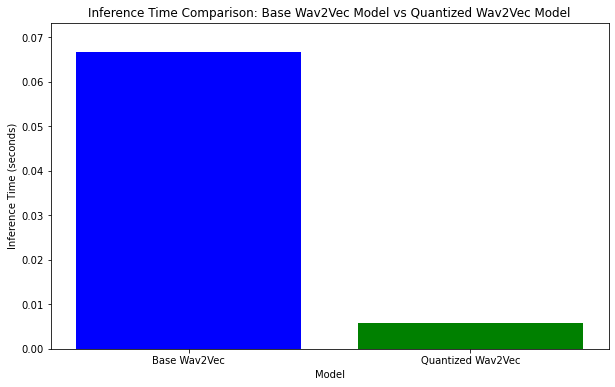

In [53]:
import matplotlib.pyplot as plt

models = ['Base Wav2Vec', 'Quantized Wav2Vec']
inference_times = [0.0666208267211914, 0.005755901336669922]

plt.figure(figsize=(10, 6))
plt.bar(models, inference_times, color=['blue', 'green'])
plt.xlabel('Model')
plt.ylabel('Inference Time (seconds)')
plt.title('Inference Time Comparison: Base Wav2Vec Model vs Quantized Wav2Vec Model')
plt.ylim(0, max(inference_times) * 1.1)
plt.show()


We adjust the graph to use log scale to make the quantized Wav2Vec model time more visible

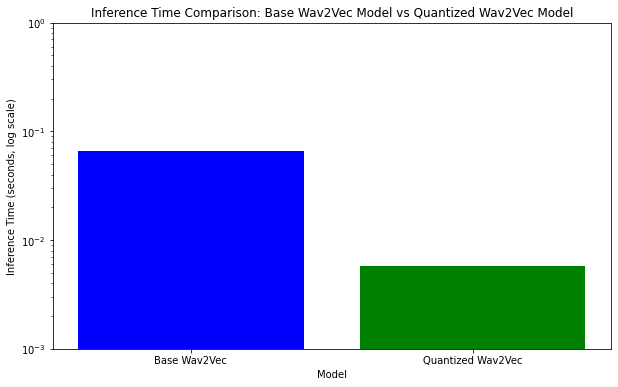

In [54]:
plt.figure(figsize=(10, 6))
plt.bar(models, inference_times, color=['blue', 'green'])
plt.xlabel('Model')
plt.ylabel('Inference Time (seconds, log scale)')
plt.title('Inference Time Comparison: Base Wav2Vec Model vs Quantized Wav2Vec Model')
plt.yscale('log')
plt.ylim(0.001, 1)
plt.show()

At the end, we calculate how many times the quantized model is faster than the base model

In [56]:
base_model_time = 0.0666208267211914
quantized_model_time = 0.005755901336669922

speedup_ratio = base_model_time / quantized_model_time
print(f'Quantized fine-tuned wav2vec2 is {round(speedup_ratio)} times faster than base fine-tuned wav2vec2')

Quantized fine-tuned wav2vec2 is 12 times faster than base fine-tuned wav2vec2
